# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [22]:
import numpy as np
import scipy
import os
import imageio
from imageio import imread
from skimage.transform import resize
#from scipy.misc import imresize
#import imageio.imread
import datetime
import os
import matplotlib.pyplot as plt
%matplotlib inline

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In [4]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
else:
    print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
train_doc = np.random.permutation(open(r'D:\Upgrad Data Science PGDDS\Course 4 Deep Learning\Module 6 Deep Learning Case Study\Project_data\train.csv').readlines())
val_doc = np.random.permutation(open(r'D:\Upgrad Data Science PGDDS\Course 4 Deep Learning\Module 6 Deep Learning Case Study\Project_data\val.csv').readlines())
batch_size = 20

In [6]:
#To check the GPU Usage
!nvidia-smi

Thu Sep 16 15:11:12 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.68       Driver Version: 471.68       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:06:00.0 Off |                  N/A |
| N/A   54C    P0    N/A /  N/A |   1912MiB /  2048MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [7]:
#Function to plot the model's validation and training loss and accuracy
def plot(history):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
    axes[0].plot(history.history.history['loss'])   
    axes[0].plot(history.history.history['val_loss'])
    axes[0].legend(['loss','val_loss'])

    axes[1].plot(history.history.history['categorical_accuracy'])   
    axes[1].plot(history.history.history['val_categorical_accuracy'])
    axes[1].legend(['categorical_accuracy','val_categorical_accuracy'])

In [23]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.round(np.linspace(0,29,19)).astype(int)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list)/batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),75,75,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image=resize(image,(75,75))
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if len(folder_list)%batch_size != 0:
            batch_size = len(folder_list)%batch_size
            batch_data = np.zeros((batch_size,len(img_idx),75,75,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image=resize(image,(75,75))
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [24]:
import datetime
curr_dt_time = datetime.datetime.now()
train_path = (r'D:\Upgrad Data Science PGDDS\Course 4 Deep Learning\Module 6 Deep Learning Case Study\Project_data\train')
val_path = (r'D:\Upgrad Data Science PGDDS\Course 4 Deep Learning\Module 6 Deep Learning Case Study\Project_data\val')
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 20
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 20


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

## Conv3D Model(Base Model)

In [26]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers
from keras.layers import Dense, Softmax, Dropout

model_Conv3D = Sequential()
model_Conv3D.add(Conv3D(16, (2, 2, 2),padding='same', input_shape=(19,75,75,3)))
model_Conv3D.add(Activation('relu'))
model_Conv3D.add(BatchNormalization())
model_Conv3D.add(MaxPooling3D(pool_size=(2, 2, 2)))


model_Conv3D.add(Conv3D(32, (2, 2, 2),padding='same'))
model_Conv3D.add(Activation('relu'))
model_Conv3D.add(BatchNormalization())
model_Conv3D.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_Conv3D.add(Conv3D(64, (2, 2, 2),padding='same'))
model_Conv3D.add(Activation('relu'))
model_Conv3D.add(BatchNormalization())
model_Conv3D.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_Conv3D.add(Flatten())
model_Conv3D.add(Dense(128,activation='relu'))
model_Conv3D.add(BatchNormalization())
model_Conv3D.add(Dropout(0.2))

model_Conv3D.add(Dense(64,activation='relu'))
model_Conv3D.add(BatchNormalization())


model_Conv3D.add(Dense(5,activation='softmax'))

In [27]:
optimiser = tf.keras.optimizers.Adam()
model_Conv3D.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_Conv3D.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_9 (Conv3D)            (None, 19, 75, 75, 16)    400       
_________________________________________________________________
activation_9 (Activation)    (None, 19, 75, 75, 16)    0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 19, 75, 75, 16)    64        
_________________________________________________________________
max_pooling3d_9 (MaxPooling3 (None, 9, 37, 37, 16)     0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 9, 37, 37, 32)     4128      
_________________________________________________________________
activation_10 (Activation)   (None, 9, 37, 37, 32)     0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 9, 37, 37, 32)    

In [28]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [29]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False,
                             mode='auto', save_weights_only=False, period=1)
LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.2, patience = 4,verbose = 1)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [30]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [31]:
model_Conv3D.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator,callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\deabh\anaconda3\envs\tf1\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Source path =  D:\Upgrad Data Science PGDDS\Course 4 Deep Learning\Module 6 Deep Learning Case Study\Project_data\train ; batch size = 20
Epoch 1/20
34/34 [==============================] - 167s 5s/step - loss: 1.0446 - categorical_accuracy: 0.5958 - val_loss: 2.3896 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to model_init_2021-09-1605_37_00.979671\model-00001-1.04464-0.59578-2.38959-0.16000.h5
Epoch 2/20
34/34 [==============================] - 47s 1s/step - loss: 1.1765 - categorical_accuracy: 0.5490 - val_loss: 3.4321 - val_categorical_accuracy: 0.1400

Epoch 00002: saving model to model_init_2021-09-1605_37_00.979671\model-00002-1.17655-0.54902-3.43207-0.14000.h5
Epoch 3/20
34/34 [==============================] - 47s 1s/step - loss: 1.3999 - categorical_accuracy: 0.4020 - val_loss: 4.9781 - val_categorical_accuracy: 0.1600

Epoch 00003: saving model to model_init_2021-09-1605_37_00.979671\model-00003-1.39991-0.40196-4.97810-0.16000.h5
Epoch 4/20
34/34 [=========

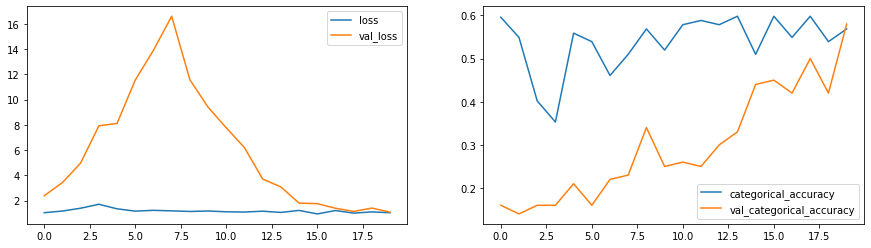

In [32]:
plot(model_Conv3D)

**Model has low accuracy though the model is fitting well.**

### Reducing the parameters

In [33]:
model_Conv3D2 = Sequential()
model_Conv3D2.add(Conv3D(16, (2, 2, 2),padding='same', input_shape=(19,75,75,3)))
model_Conv3D2.add(Activation('relu'))
model_Conv3D2.add(BatchNormalization())
model_Conv3D2.add(MaxPooling3D(pool_size=(2, 2, 2)))


model_Conv3D2.add(Conv3D(32, (2, 2, 2),padding='same'))
model_Conv3D2.add(Activation('relu'))
model_Conv3D2.add(BatchNormalization())
model_Conv3D2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_Conv3D2.add(Conv3D(64, (2, 2, 2),padding='same'))
model_Conv3D2.add(Activation('relu'))
model_Conv3D2.add(BatchNormalization())
model_Conv3D2.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_Conv3D2.add(Flatten())
#model_Conv3D.add(Dense(128,activation='relu'))
#model_Conv3D.add(BatchNormalization())
#model_Conv3D.add(Dropout(0.25))

model_Conv3D2.add(Dense(64,activation='relu'))
model_Conv3D2.add(BatchNormalization())
model_Conv3D2.add(Dropout(0.2))


model_Conv3D2.add(Dense(5,activation='softmax'))

In [34]:
optimiser = tf.keras.optimizers.Adam()
model_Conv3D2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_Conv3D2.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_12 (Conv3D)           (None, 19, 75, 75, 16)    400       
_________________________________________________________________
activation_12 (Activation)   (None, 19, 75, 75, 16)    0         
_________________________________________________________________
batch_normalization_20 (Batc (None, 19, 75, 75, 16)    64        
_________________________________________________________________
max_pooling3d_12 (MaxPooling (None, 9, 37, 37, 16)     0         
_________________________________________________________________
conv3d_13 (Conv3D)           (None, 9, 37, 37, 32)     4128      
_________________________________________________________________
activation_13 (Activation)   (None, 9, 37, 37, 32)     0         
_________________________________________________________________
batch_normalization_21 (Batc (None, 9, 37, 37, 32)    

In [35]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [36]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False,
                             mode='auto', save_weights_only=False, period=1)
LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.2, patience = 4,verbose = 1)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [37]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [38]:
model_Conv3D2.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator,callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\deabh\anaconda3\envs\tf1\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Source path =  D:\Upgrad Data Science PGDDS\Course 4 Deep Learning\Module 6 Deep Learning Case Study\Project_data\train ; batch size = 20
Epoch 1/20
34/34 [==============================] - 167s 5s/step - loss: 1.0095 - categorical_accuracy: 0.6139 - val_loss: 4.5211 - val_categorical_accuracy: 0.2100

Epoch 00001: saving model to model_init_2021-09-1605_37_00.979671\model-00001-1.00950-0.61388-4.52105-0.21000.h5
Epoch 2/20
34/34 [==============================] - 42s 1s/step - loss: 0.8228 - categorical_accuracy: 0.6863 - val_loss: 8.6217 - val_categorical_accuracy: 0.2000

Epoch 00002: saving model to model_init_2021-09-1605_37_00.979671\model-00002-0.82277-0.68627-8.62170-0.20000.h5
Epoch 3/20
34/34 [==============================] - 46s 1s/step - loss: 0.8430 - categorical_accuracy: 0.6961 - val_loss: 13.3605 - val_categorical_accuracy: 0.2200

Epoch 00003: saving model to model_init_2021-09-1605_37_00.979671\model-00003-0.84296-0.69608-13.36047-0.22000.h5
Epoch 4/20
34/34 [=======

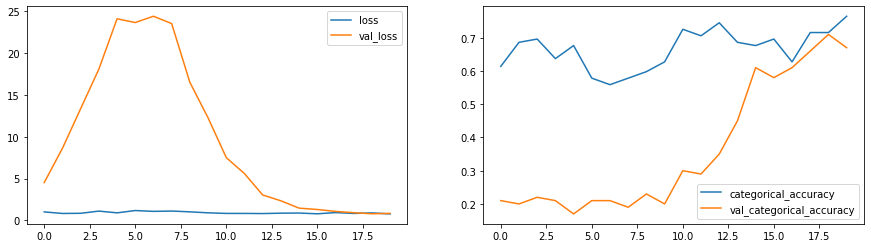

In [39]:
plot(model_Conv3D2)

**Model's accuracy increased for training and validation set by a good margin after reducing the parameters.**

### Increasing the filter size (3x3x3)

In [40]:
model_Conv3D1 = Sequential()
model_Conv3D1.add(Conv3D(16, (3, 3, 3),padding='same', input_shape=(19,75,75,3)))
model_Conv3D1.add(Activation('relu'))
model_Conv3D1.add(BatchNormalization())
model_Conv3D1.add(MaxPooling3D(pool_size=(2, 2, 2)))


model_Conv3D1.add(Conv3D(32, (3, 3, 3),padding='same'))
model_Conv3D1.add(Activation('relu'))
model_Conv3D1.add(BatchNormalization())
model_Conv3D1.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_Conv3D1.add(Conv3D(64, (3, 3, 3),padding='same'))
model_Conv3D1.add(Activation('relu'))
model_Conv3D1.add(BatchNormalization())
model_Conv3D1.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_Conv3D1.add(Flatten())
model_Conv3D1.add(Dense(128,activation='relu'))
model_Conv3D1.add(BatchNormalization())
#model_Conv3D1.add(Dropout(0.25))

model_Conv3D1.add(Dense(64,activation='relu'))
model_Conv3D1.add(BatchNormalization())
model_Conv3D1.add(Dropout(0.2))


model_Conv3D1.add(Dense(5,activation='softmax'))

In [41]:
optimiser = tf.keras.optimizers.Adam()
model_Conv3D1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_Conv3D1.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_15 (Conv3D)           (None, 19, 75, 75, 16)    1312      
_________________________________________________________________
activation_15 (Activation)   (None, 19, 75, 75, 16)    0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 19, 75, 75, 16)    64        
_________________________________________________________________
max_pooling3d_15 (MaxPooling (None, 9, 37, 37, 16)     0         
_________________________________________________________________
conv3d_16 (Conv3D)           (None, 9, 37, 37, 32)     13856     
_________________________________________________________________
activation_16 (Activation)   (None, 9, 37, 37, 32)     0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 9, 37, 37, 32)    

In [42]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [43]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [44]:
num_epochs=25

In [45]:
model_Conv3D1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator,callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\deabh\anaconda3\envs\tf1\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Source path =  D:\Upgrad Data Science PGDDS\Course 4 Deep Learning\Module 6 Deep Learning Case Study\Project_data\train ; batch size = 20
Epoch 1/25
34/34 [==============================] - 164s 5s/step - loss: 1.3537 - categorical_accuracy: 0.5053 - val_loss: 1.4786 - val_categorical_accuracy: 0.3200

Epoch 00001: saving model to model_init_2021-09-1605_37_00.979671\model-00001-1.35370-0.50528-1.47859-0.32000.h5
Epoch 2/25
34/34 [==============================] - 55s 2s/step - loss: 1.4433 - categorical_accuracy: 0.4216 - val_loss: 1.8546 - val_categorical_accuracy: 0.2100

Epoch 00002: saving model to model_init_2021-09-1605_37_00.979671\model-00002-1.44334-0.42157-1.85457-0.21000.h5
Epoch 3/25
34/34 [==============================] - 51s 2s/step - loss: 1.6583 - categorical_accuracy: 0.3333 - val_loss: 1.6066 - val_categorical_accuracy: 0.3100

Epoch 00003: saving model to model_init_2021-09-1605_37_00.979671\model-00003-1.65833-0.33333-1.60659-0.31000.h5
Epoch 4/25
34/34 [=========

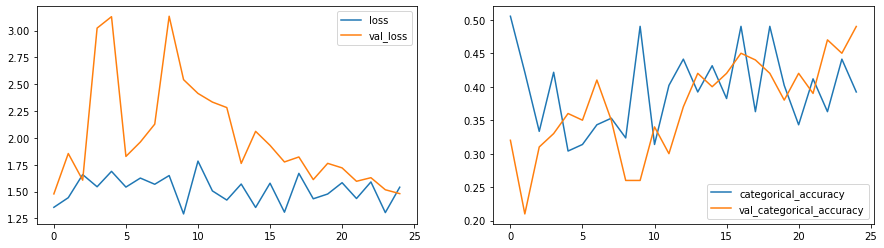

In [46]:
plot(model_Conv3D1)

**This model performs poorly than the previous one.**

### Reducing the parameters of the above model

In [55]:
model_Conv3D3 = Sequential()
model_Conv3D3.add(Conv3D(16, (3, 3, 3),padding='same', input_shape=(19,75,75,3)))
model_Conv3D3.add(Activation('relu'))
model_Conv3D3.add(BatchNormalization())
model_Conv3D3.add(MaxPooling3D(pool_size=(2, 2, 2)))


model_Conv3D3.add(Conv3D(32, (3, 3, 3),padding='same'))
model_Conv3D3.add(Activation('relu'))
model_Conv3D3.add(BatchNormalization())
model_Conv3D3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_Conv3D3.add(Conv3D(64, (3, 3, 3),padding='same'))
model_Conv3D3.add(Activation('relu'))
model_Conv3D3.add(BatchNormalization())
model_Conv3D3.add(MaxPooling3D(pool_size=(2, 2, 2)))

model_Conv3D3.add(Flatten())
#model_Conv3D1.add(Dense(128,activation='relu'))
#model_Conv3D1.add(BatchNormalization())
#model_Conv3D1.add(Dropout(0.25))

model_Conv3D3.add(Dense(64,activation='relu'))
model_Conv3D3.add(BatchNormalization())
model_Conv3D3.add(Dropout(0.2))


model_Conv3D3.add(Dense(5,activation='softmax'))

In [56]:
optimiser = tf.keras.optimizers.Adam()
model_Conv3D3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_Conv3D3.summary())

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_21 (Conv3D)           (None, 19, 75, 75, 16)    1312      
_________________________________________________________________
activation_21 (Activation)   (None, 19, 75, 75, 16)    0         
_________________________________________________________________
batch_normalization_33 (Batc (None, 19, 75, 75, 16)    64        
_________________________________________________________________
max_pooling3d_21 (MaxPooling (None, 9, 37, 37, 16)     0         
_________________________________________________________________
conv3d_22 (Conv3D)           (None, 9, 37, 37, 32)     13856     
_________________________________________________________________
activation_22 (Activation)   (None, 9, 37, 37, 32)     0         
_________________________________________________________________
batch_normalization_34 (Batc (None, 9, 37, 37, 32)    

In [57]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [58]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [59]:
num_epochs=20

In [60]:
model_Conv3D3.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator,callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  D:\Upgrad Data Science PGDDS\Course 4 Deep Learning\Module 6 Deep Learning Case Study\Project_data\train ; batch size = 20
Epoch 1/20
12/34 [=========>....................] - ETA: 1:23 - loss: 1.3608 - categorical_accuracy: 0.4917

KeyboardInterrupt: 

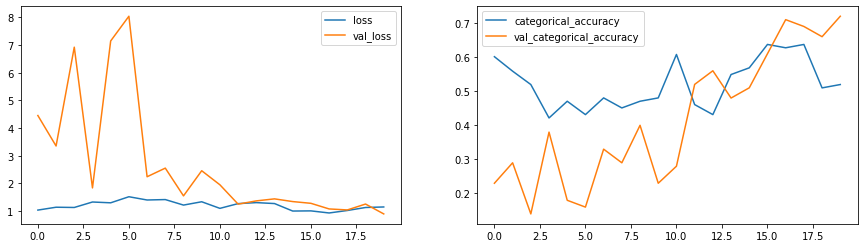

In [54]:
plot(model_Conv3D3)

**Though the accuracy has impproved than the previous model but still this model is not that good for this data.**

## Conv2D with  LSTM Model

In [61]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D,Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from keras import optimizers
from keras.layers import Dense, Softmax, Dropout,LSTM

In [62]:
model_CNN_LSTM = Sequential()

model_CNN_LSTM.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(19,75,75,3)))
model_CNN_LSTM.add(TimeDistributed(BatchNormalization()))
model_CNN_LSTM.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_CNN_LSTM.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_CNN_LSTM.add(TimeDistributed(BatchNormalization()))
model_CNN_LSTM.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_CNN_LSTM.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_CNN_LSTM.add(TimeDistributed(BatchNormalization()))
model_CNN_LSTM.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_CNN_LSTM.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_CNN_LSTM.add(TimeDistributed(BatchNormalization()))
model_CNN_LSTM.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_CNN_LSTM.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model_CNN_LSTM.add(TimeDistributed(BatchNormalization()))
model_CNN_LSTM.add(TimeDistributed(MaxPooling2D((2, 2))))

model_CNN_LSTM.add(TimeDistributed(Flatten()))


model_CNN_LSTM.add(LSTM(128))
        
model_CNN_LSTM.add(Dense(128,activation='relu'))
model_CNN_LSTM.add(Dropout(0.2))
        
model_CNN_LSTM.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [63]:
optimiser = tf.keras.optimizers.Adam()
model_CNN_LSTM.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_CNN_LSTM.summary())

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 19, 75, 75, 16)    448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 19, 75, 75, 16)    64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 19, 37, 37, 16)    0         
_________________________________________________________________
time_distributed_3 (TimeDist (None, 19, 37, 37, 32)    4640      
_________________________________________________________________
time_distributed_4 (TimeDist (None, 19, 37, 37, 32)    128       
_________________________________________________________________
time_distributed_5 (TimeDist (None, 19, 18, 18, 32)    0         
_________________________________________________________________
time_distributed_6 (TimeDist (None, 19, 18, 18, 64)   

In [64]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [65]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [66]:
model_CNN_LSTM.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator,callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  D:\Upgrad Data Science PGDDS\Course 4 Deep Learning\Module 6 Deep Learning Case Study\Project_data\train ; batch size = 20
Epoch 1/20
34/34 [==============================] - 149s 4s/step - loss: 1.2519 - categorical_accuracy: 0.5083 - val_loss: 1.8168 - val_categorical_accuracy: 0.1600

Epoch 00001: saving model to model_init_2021-09-1605_37_00.979671\model-00001-1.25191-0.50830-1.81678-0.16000.h5
Epoch 2/20
34/34 [==============================] - 39s 1s/step - loss: 1.1998 - categorical_accuracy: 0.4706 - val_loss: 2.2780 - val_categorical_accuracy: 0.1700

Epoch 00002: saving model to model_init_2021-09-1605_37_00.979671\model-00002-1.19979-0.47059-2.27798-0.17000.h5
Epoch 3/20
34/34 [==============================] - 48s 1s/step - loss: 1.2019 - categorical_accuracy: 0.5294 - val_loss: 2.4092 - val_categorical_accuracy: 0.1600

Epoch 00003: saving model to model_init_2021-09-1605_37_00.979671\model-00003-1.20188-0.52941-2.40917-0.16000.h5
Epoch 4/20
34/34 [=========

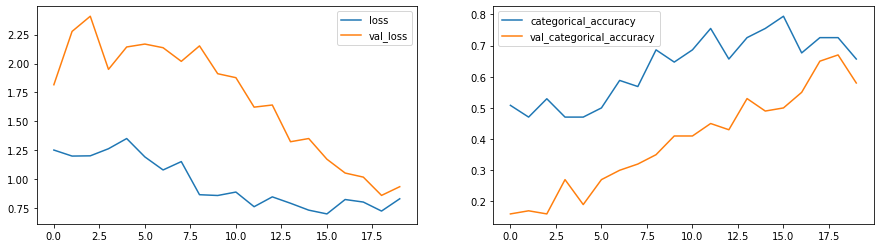

In [67]:
plot(model_CNN_LSTM)

**THis model performs good for both training and validation set. Accuracy scores are also decent.**

### Model with reduced parameters

In [74]:
model_CNN_LSTM1 = Sequential()

model_CNN_LSTM1.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                                  input_shape=(19,75,75,3)))
model_CNN_LSTM1.add(TimeDistributed(BatchNormalization()))
model_CNN_LSTM1.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_CNN_LSTM1.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model_CNN_LSTM1.add(TimeDistributed(BatchNormalization()))
model_CNN_LSTM1.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_CNN_LSTM1.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model_CNN_LSTM1.add(TimeDistributed(BatchNormalization()))
model_CNN_LSTM1.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_CNN_LSTM1.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model_CNN_LSTM1.add(TimeDistributed(BatchNormalization()))
model_CNN_LSTM1.add(TimeDistributed(MaxPooling2D((2, 2))))
        
model_CNN_LSTM1.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
model_CNN_LSTM1.add(TimeDistributed(BatchNormalization()))
model_CNN_LSTM1.add(TimeDistributed(MaxPooling2D((2, 2))))

model_CNN_LSTM1.add(TimeDistributed(Flatten()))

model_CNN_LSTM1.add(LSTM(128))
        
model_CNN_LSTM1.add(Dense(64,activation='relu'))
model_CNN_LSTM1.add(Dropout(0.2))
        
model_CNN_LSTM1.add(Dense(5, activation='softmax'))

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [75]:
optimiser = tf.keras.optimizers.Adam()
model_CNN_LSTM1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model_CNN_LSTM1.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_32 (TimeDis (None, 19, 75, 75, 16)    448       
_________________________________________________________________
time_distributed_33 (TimeDis (None, 19, 75, 75, 16)    64        
_________________________________________________________________
time_distributed_34 (TimeDis (None, 19, 37, 37, 16)    0         
_________________________________________________________________
time_distributed_35 (TimeDis (None, 19, 37, 37, 32)    4640      
_________________________________________________________________
time_distributed_36 (TimeDis (None, 19, 37, 37, 32)    128       
_________________________________________________________________
time_distributed_37 (TimeDis (None, 19, 18, 18, 32)    0         
_________________________________________________________________
time_distributed_38 (TimeDis (None, 19, 18, 18, 64)  

In [76]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [77]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [78]:
model_CNN_LSTM1.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator,callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\deabh\anaconda3\envs\tf1\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Source path =  D:\Upgrad Data Science PGDDS\Course 4 Deep Learning\Module 6 Deep Learning Case Study\Project_data\train ; batch size = 20
Epoch 1/20
34/34 [==============================] - 165s 5s/step - loss: 1.4191 - categorical_accuracy: 0.3816 - val_loss: 1.5270 - val_categorical_accuracy: 0.3000

Epoch 00001: saving model to model_init_2021-09-1605_37_00.979671\model-00001-1.41913-0.38160-1.52697-0.30000.h5
Epoch 2/20
34/34 [==============================] - 50s 2s/step - loss: 1.3168 - categorical_accuracy: 0.4706 - val_loss: 1.8275 - val_categorical_accuracy: 0.2200

Epoch 00002: saving model to model_init_2021-09-1605_37_00.979671\model-00002-1.31682-0.47059-1.82752-0.22000.h5
Epoch 3/20
34/34 [==============================] - 52s 2s/step - loss: 1.4357 - categorical_accuracy: 0.3922 - val_loss: 1.7676 - val_categorical_accuracy: 0.2900

Epoch 00003: saving model to model_init_2021-09-1605_37_00.979671\model-00003-1.43567-0.39216-1.76757-0.29000.h5
Epoch 4/20
34/34 [=========

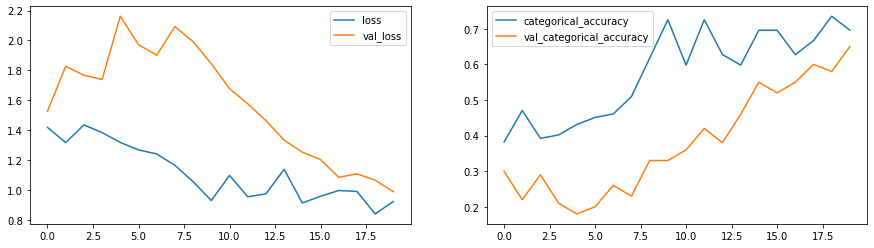

In [79]:
plot(model_CNN_LSTM1)

**The accuracy scores have dropped a little after reducing the parameters but still  good model to run.**

# Transfer Learning with 2D CNN Layer

In [8]:
batch_size=50
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.round(np.linspace(0,29,18)).astype(int)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = int(len(folder_list)/batch_size)
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,len(img_idx),100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image=resize(image,(100,100))
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if len(folder_list)%batch_size != 0:
            batch_size = len(folder_list)%batch_size
            batch_data = np.zeros((batch_size,len(img_idx),100,100,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    image=resize(image,(100,100))
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [13]:
import datetime
curr_dt_time = datetime.datetime.now()
train_path = (r'D:\Upgrad Data Science PGDDS\Course 4 Deep Learning\Module 6 Deep Learning Case Study\Project_data\train')
val_path = (r'D:\Upgrad Data Science PGDDS\Course 4 Deep Learning\Module 6 Deep Learning Case Study\Project_data\val')
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 30
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 30


## Transfer Learning with LSTM

In [14]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from keras.layers.convolutional import Conv3D, MaxPooling3D,Conv2D,MaxPooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping
from keras import optimizers
from keras.layers import Dense, Softmax, Dropout,LSTM

In [15]:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights="imagenet", include_top=False)

model = Sequential()
model.add(TimeDistributed(mobilenet_transfer,input_shape=(18,100,100,3)))

for layer in model.layers:
    layer.trainable= False
model.add(TimeDistributed(BatchNormalization()))
model.add(TimeDistributed(MaxPooling2D((2, 2))))
model.add(TimeDistributed(Flatten()))

model.add(LSTM(256))
model.add(Dropout(0.2))
        
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.2))
        
model.add(Dense(5, activation='softmax'))

In [16]:
optimiser = tf.keras.optimizers.Adam()
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_4 (TimeDist (None, 18, 3, 3, 1024)    3228864   
_________________________________________________________________
time_distributed_5 (TimeDist (None, 18, 3, 3, 1024)    4096      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 18, 1, 1, 1024)    0         
_________________________________________________________________
time_distributed_7 (TimeDist (None, 18, 1024)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               1311744   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)              

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [17]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [18]:
model_name = 'model_init' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False,
                             mode='auto', save_weights_only=False, period=1)
LR = ReduceLROnPlateau(monitor = "val_loss", factor = 0.2, patience = 4,verbose = 1)
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [19]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [20]:
model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    validation_data=val_generator,callbacks=callbacks_list,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

C:\Users\deabh\anaconda3\envs\tf1\lib\site-packages\keras\engine\training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Source path =  D:\Upgrad Data Science PGDDS\Course 4 Deep Learning\Module 6 Deep Learning Case Study\Project_data\train ; batch size = 50
Epoch 1/30
14/14 [==============================] - 209s 14s/step - loss: 1.3347 - categorical_accuracy: 0.4359 - val_loss: 0.9718 - val_categorical_accuracy: 0.6700

Epoch 00001: saving model to model_init_2021-09-1615_11_43.745668\model-00001-1.33467-0.43590-0.97185-0.67000.h5
Epoch 2/30
14/14 [==============================] - 76s 6s/step - loss: 0.7349 - categorical_accuracy: 0.7253 - val_loss: 1.2152 - val_categorical_accuracy: 0.4500

Epoch 00002: saving model to model_init_2021-09-1615_11_43.745668\model-00002-0.73493-0.72527-1.21524-0.45000.h5
Epoch 3/30
14/14 [==============================] - 85s 7s/step - loss: 0.5437 - categorical_accuracy: 0.8516 - val_loss: 0.8031 - val_categorical_accuracy: 0.6900

Epoch 00003: saving model to model_init_2021-09-1615_11_43.745668\model-00003-0.54373-0.85165-0.80307-0.69000.h5
Epoch 4/30
14/14 [========

14/14 [==============================] - 80s 6s/step - loss: 0.0080 - categorical_accuracy: 1.0000 - val_loss: 0.8346 - val_categorical_accuracy: 0.8000

Epoch 00028: saving model to model_init_2021-09-1615_11_43.745668\model-00028-0.00800-1.00000-0.83459-0.80000.h5
Epoch 29/30
14/14 [==============================] - 77s 6s/step - loss: 0.0151 - categorical_accuracy: 0.9945 - val_loss: 0.8228 - val_categorical_accuracy: 0.8000

Epoch 00029: saving model to model_init_2021-09-1615_11_43.745668\model-00029-0.01509-0.99451-0.82284-0.80000.h5
Epoch 30/30
14/14 [==============================] - 76s 6s/step - loss: 0.0095 - categorical_accuracy: 1.0000 - val_loss: 0.9725 - val_categorical_accuracy: 0.7800

Epoch 00030: saving model to model_init_2021-09-1615_11_43.745668\model-00030-0.00951-1.00000-0.97247-0.78000.h5

Epoch 00030: ReduceLROnPlateau reducing learning rate to 1.6000001778593287e-06.


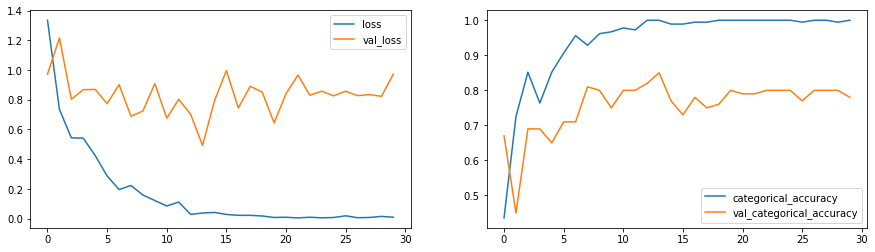

In [21]:
plot(model)

1. **This is our best model though it overfits the model. Picking up a good validation and training score .h5 model would do a good job.**
2. **This model(MobileNet) has high accuracy and has a 100% training accuracy.**
3. **We are gonna submit the 8th epoch h5 file because it has a training accuracy of 92% and a validation accuracy of 81% which are decent as well.**